In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
from random import choices
from scipy.interpolate import interp1d
from scipy.stats import kstest
from ang_res_funcs import *

In [2]:
PARENT_DIRECTORY = '/data/ana/CosmicRay/Anisotropy/IceTop/twelve_year/03_sim_study'
COLORS = ['green', 'blue', 'red']
YEARS = ['2012', '2015', '2018']

In [3]:
# Histogram storage and setup
energy_hist = defaultdict(lambda: defaultdict(np.array))
density_hist = defaultdict(lambda: defaultdict(np.array))
weighted_uncertainty = defaultdict(lambda: defaultdict(np.array))
relative_weights = defaultdict(lambda: defaultdict(np.array))

# Bins and scale designed for display in PeV
bins = 10**(np.arange(-1,2,.1))
bin_centers = (bins[:-1] + bins[1:]) / 2
scale = 10**-6

for TIER in [3,4]:
    
    for YEAR in YEARS:

        energies = []
        weights = []

        # Populate energies and weights
        for COMP in ['Proton','Helium','Oxygen','Iron']:
            energies += list(np.load(f'{PARENT_DIRECTORY}/IT81-{YEAR}/{COMP}-T{TIER}-MC-Energy.npy'))
            weights += list(np.load(f'{PARENT_DIRECTORY}/IT81-{YEAR}/{COMP}-T{TIER}-MC-Weights.npy'))

        # Scale energies and normalize weights
        energies = np.asarray(energies) * scale
        #weights = np.asarray(weights) / np.sum(weights)
        weights = np.asarray(weights)
        
        energy_hist[TIER][YEAR] = np.histogram(energies, bins=bins, weights=weights)[0]
        weighted_uncertainty[TIER][YEAR] = np.sqrt(np.histogram(energies, bins=bins, weights=weights**2)[0])
        density_hist[TIER][YEAR] = np.histogram(energies, bins=bins, weights=weights, density=True)[0]
        # Fancier division function for relative weights takes care of 0's in divisor
        relative_weights[TIER][YEAR] = np.divide(weighted_uncertainty[TIER][YEAR], energy_hist[TIER][YEAR], out=np.zeros_like(weighted_uncertainty[TIER][YEAR]), where=energy_hist[TIER][YEAR]!=0)

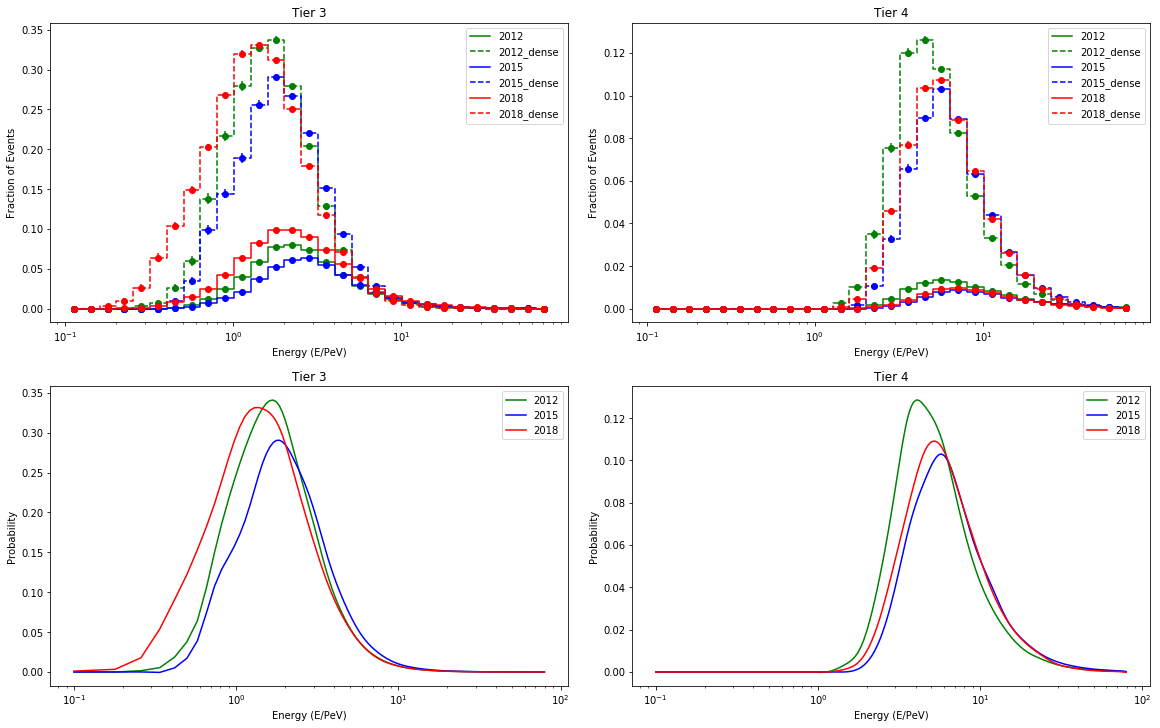

In [4]:
# Initialize histogram array
histograms = plt.figure(figsize=(16, 10), constrained_layout=True)
hist_array = histograms.subplots(2, 2, squeeze=False)

for row, h_i in enumerate(hist_array):
    for col, ax in enumerate(h_i):
        
        TIER = 3 if col==0 else 4
        
        # Normalized histograms of energy distributions in first row
        if row == 0:
            for i, YEAR in enumerate(YEARS):
                ax.step(bin_centers, energy_hist[TIER][YEAR], where='mid', color=COLORS[i], label=YEAR)
                ax.errorbar(bin_centers, energy_hist[TIER][YEAR], yerr=weighted_uncertainty[TIER][YEAR], fmt='o', color=COLORS[i])
                ax.step(bin_centers, density_hist[TIER][YEAR], where='mid', color=COLORS[i], label=f'{YEAR}_dense', linestyle='dashed')
                ax.errorbar(bin_centers, density_hist[TIER][YEAR], yerr=relative_weights[TIER][YEAR]*density_hist[TIER][YEAR], fmt='o', color=COLORS[i])
            ylabel = 'Fraction of Events'
        
        # PDFs in second row
        elif row == 1:
            for i, YEAR in enumerate(YEARS):
                interp_function = interp1d(bin_centers, density_hist[TIER][YEAR], kind='cubic', fill_value='extrapolate')
                x = np.linspace(bins[0], bins[-1], 1000)       
                y = interp_function(x)
                ax.plot(x, y, label=YEAR, color=COLORS[i])
            ylabel = 'Probability'
        
        ax.set_title(f'Tier {TIER}')
        ax.semilogx()
        ax.set_ylabel(ylabel)
        ax.set_xlabel('Energy (E/PeV)')
        ax.legend()

plt.show()

In [5]:
for TIER in [3,4]:
    
    print(f'Tier {TIER}:')
    pdf_2012 = interp1d(bin_centers, density_hist[TIER]['2012'], kind='cubic', fill_value='extrapolate')
    
    for YEAR in YEARS:
        
        def inverse_transform_sampling(size=100):
            cum_values = np.zeros(bins.shape)
            cum_values[1:] = np.cumsum(density_hist[TIER][YEAR] * np.diff(bins))
            inv_cdf = interp1d(cum_values, bins)
            r = np.random.rand(size)
            return inv_cdf(r)

        ks_stat, p_value = kstest(inverse_transform_sampling, lambda x: pdf_2012(x))
        print(f'  2012 and {YEAR}: p-value = {p_value}')


Tier 3:
  2012 and 2012: p-value = 8.852782724773727e-83
  2012 and 2015: p-value = 1.5387458149303568e-26
  2012 and 2018: p-value = 9.937330823894773e-28
Tier 4:
  2012 and 2012: p-value = 9.367110770158159e-64
  2012 and 2015: p-value = 1.7020908944646909e-53
  2012 and 2018: p-value = 1.9204318594320937e-55


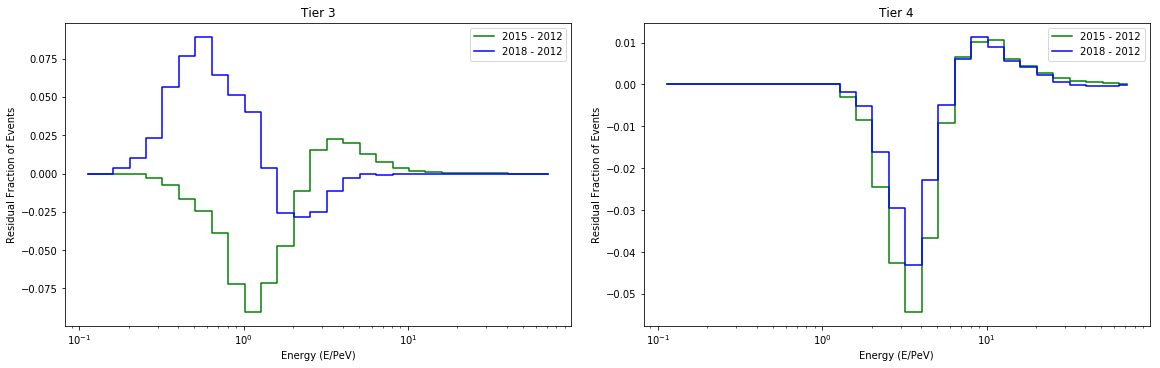

In [6]:
# Create residual plots
histograms = plt.figure(figsize=(16, 5), constrained_layout=True)
hist_array = histograms.subplots(1, 2, squeeze=False)

for row, h_i in enumerate(hist_array):
    for col, ax in enumerate(h_i):
        
        TIER = 3 if col==0 else 4
        
        ax.step(bin_centers, density_hist[TIER]['2015'] - density_hist[TIER]['2012'], where='mid', color=COLORS[0], label='2015 - 2012')
        ax.step(bin_centers, density_hist[TIER]['2018'] - density_hist[TIER]['2012'], where='mid', color=COLORS[1], label='2018 - 2012')
        ylabel = 'Residual Fraction of Events'
        
        ax.set_title(f'Tier {TIER}')
        ax.semilogx()
        ax.set_ylabel(ylabel)
        ax.set_xlabel('Energy (E/PeV)')
        ax.legend()

plt.show()

/cvmfs/icecube.opensciencegrid.org/py3-v4.1.1/Ubuntu_20.04_x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/cvmfs/icecube.opensciencegrid.org/py3-v4.1.1/Ubuntu_20.04_x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/cvmfs/icecube.opensciencegrid.org/py3-v4.1.1/Ubuntu_20.04_x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


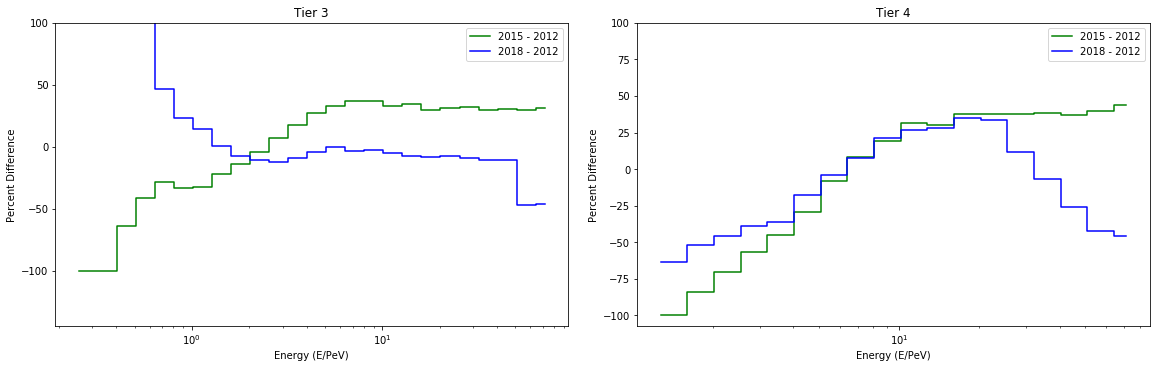

In [10]:
# Create residual plots
histograms = plt.figure(figsize=(16, 5), constrained_layout=True)
hist_array = histograms.subplots(1, 2, squeeze=False)

y_upper_limit = 100
for row, h_i in enumerate(hist_array):
    for col, ax in enumerate(h_i):
        
        TIER = 3 if col==0 else 4
        
        ax.step(bin_centers, (density_hist[TIER]['2015'] - density_hist[TIER]['2012']) * 100 / density_hist[TIER]['2012'], where='mid', color=COLORS[0], label='2015 - 2012')
        ax.step(bin_centers, (density_hist[TIER]['2018'] - density_hist[TIER]['2012']) * 100 / density_hist[TIER]['2012'], where='mid', color=COLORS[1], label='2018 - 2012')
        ylabel = 'Percent Difference'
        
        ax.set_title(f'Tier {TIER}')
        ax.semilogx()
        ax.set_ylabel(ylabel)
        ax.set_xlabel('Energy (E/PeV)')
        ax.legend()
        ax.set_ylim(top=y_upper_limit)

plt.show()